# Berlin Airbnb Data Analysis

In the following project I'm looking at data of Airbnb listings for the city of Berlin for the period of 07/2019 - 07/2020. 
The data was downloaded from the [insideairbnb.com](http://insideairbnb.com/get-the-data.html) website.

The goal of this notebook is to clean, transform and visualize the data in order to answer the three following questions:


1. Looking at the prices for Airbnb listings for Berlin, do prices differ among the Berlin neighborhoods? Do some neighborhoods have more expensive or cheaper Airbnb listings than others?

2. Do visitor numbers and listing prices fluctuate over the year?

3. How do Airbnb prices in Berlin compare to another large german city, Munich?

A short blog post discussing the results can be found [here](https://medium.com/@mpetrovic/taking-a-look-at-the-airbnb-market-in-berlin-99b45a45d11f).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Looking at the prices for Airbnb listings for Berlin, do prices differ among the different Berlin neighborhoods?

In [2]:
### Gathering the data

# Loading the listings data for Berlin
ber_listings_url = "http://data.insideairbnb.com/germany/be/berlin/2019-07-11/data/listings.csv.gz"
ber_listings = pd.read_csv(ber_listings_url)

# Loading the calendar data for Berlin
ber_calendar_url = "http://data.insideairbnb.com/germany/be/berlin/2019-07-11/data/calendar.csv.gz"
ber_calendar = pd.read_csv(ber_calendar_url)

In [3]:
### Assessing the data

# Looking at the first rows of the listings data
ber_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20190711004031,2019-07-11,cafeheaven Pberg/Mitte/Wed for the summer 2019,"Private, bright and friendly room. You'd be sh...","The room is very large, private, cozy, bright,...","Private, bright and friendly room. You'd be sh...",none,near all the trendy cafés and flea markets and...,...,f,f,moderate,f,f,1,0,1,0,0.25
1,2015,https://www.airbnb.com/rooms/2015,20190711004031,2019-07-11,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,f,f,moderate,f,f,4,4,0,0,3.18
2,3176,https://www.airbnb.com/rooms/3176,20190711004031,2019-07-11,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.18


In [4]:
# Looking at the first rows of the calendar data
ber_calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1944,2019-07-11,f,$20.00,$20.00,120,120
1,159454,2019-07-11,f,$161.00,$161.00,2,730
2,159454,2019-07-12,f,$161.00,$161.00,2,730


In [5]:
### Cleaning the data

# Function to convert the price variable to numeric
def num_price(series):
    """
    Removes the dollar sign and converts variable to numeric
    Input: string type pandas Series object
    Output: float type pandas Series object, errors are coerced to NaN
    """
    num_series = pd.to_numeric(series.str.replace("$","").str.replace(",",""), errors="coerce")
    
    return num_series

# Converting the price variable in ber_calendar to numeric
ber_calendar["price"] = num_price(ber_calendar["price"])

In [6]:
# Checking for null values that have been generated by converting to numeric
ber_calendar["price"].isnull().sum()

0

In [7]:
# Looking at the distribution of the price variable
ber_calendar["price"].describe()

count    8.904175e+06
mean     7.964042e+01
std      3.078283e+03
min      8.000000e+00
25%      3.500000e+01
50%      5.000000e+01
75%      8.000000e+01
max      9.000000e+05
Name: price, dtype: float64

In [8]:
# It seems there are many price values that are unreasonable high and unrealistic.
# We're going to take a cutoff of 2000$ per night as the maximun allowed value.  
# How many rows have a price value above that?
ber_calendar["price"][ber_calendar["price"] > 2000].count()

3847

In [9]:
# We can go ahead and drop these rows, because the price values seem to be incorrect. 
# There are also not that many rows to drop (3847) compared to the total (8904175),
# so the missing data will not have a big influence on our analysis.
ber_calendar.drop(ber_calendar[ber_calendar["price"] > 2000].index, inplace=True)

In [10]:
### Analysing the data

# Calculating the average price for every listing throughout the whole year
ber_avg_price = ber_calendar.groupby("listing_id")["price"].mean()
ber_avg_price = ber_avg_price.reset_index()

# Adding the neighbourhood_group and number of beds information to ber_avg_price
ber_avg_price = pd.merge(ber_avg_price, ber_listings[["id", "neighbourhood_group_cleansed", "beds"]], left_on="listing_id", right_on="id")
ber_avg_price = ber_avg_price[["listing_id", "neighbourhood_group_cleansed", "price", "beds"]]

# Calculating average listing price for every Berlin district
ber_price_district = ber_avg_price.groupby("neighbourhood_group_cleansed")["price"].mean().sort_values(ascending=False)
ber_price_district = ber_price_district.reset_index()

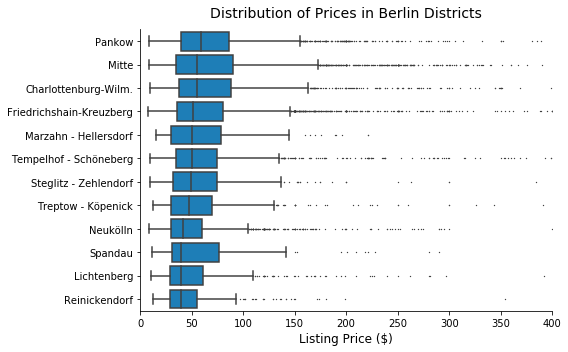

In [11]:
### Visualizing the result

plt.figure(figsize=(8,5))

flierprops = dict(markersize=0.5, linestyle='none', color="#f4f4f4")

sort_median = ber_avg_price.groupby("neighbourhood_group_cleansed")["price"].median().sort_values(ascending=False)

sns.boxplot(ber_avg_price["price"], ber_avg_price["neighbourhood_group_cleansed"], 
            orient="h", flierprops=flierprops, order=sort_median.index, color="#0485d1")

# setting x_limit to 400, because of many outliers
plt.xlim(0, 400)

plt.ylabel("")
plt.xlabel("Listing Price ($)", size=12)
plt.title("Distribution of Prices in Berlin Districts", size=14, pad=12)

sns.despine()
plt.tight_layout();

All the different district in Berlin show a surprisingly wide range of listing prices. For instance, in Berlin-Pankow prices go from 9 to 800 dollars. This wide price range could be explained by the many factors that influence the listing price, for example room number, apartment size etc.
An additional explanation could be that the chosen districts (or neighborhood groups) are very large and diverse city areas comprised of very different smaller neighborhoods that might be more or less affluent.
The district with the highest median price of 59\\$ is Berlin-Pankow. Berlin-Reinickendorf on the other hand has only a median listing price of 40$. 

One might get a better overview by looking at the 10% of the most expensive and least expensive listings repectively, and compare how they are distributed over the city:

In [12]:
### Analysing the data

# Defining the cutoffs to select the 10% of listings with the highest and lowest prices respectively
high_cutoff = ber_avg_price["price"].quantile(0.90)
low_cutoff = ber_avg_price["price"].quantile(0.10)

expensive_listings = ber_avg_price[ber_avg_price["price"] >= high_cutoff]
cheap_listings = ber_avg_price[ber_avg_price["price"] <= low_cutoff]

# Selecting the 10% of listings with the highest prices
extreme_prices = expensive_listings.groupby("neighbourhood_group_cleansed")["price"].count()
extreme_prices = extreme_prices.reset_index()
extreme_prices = extreme_prices.rename(columns={"price":"Expensive"})

# Adding the 10% of listings with the lowest prices to extreme_prices
low_prices = cheap_listings.groupby("neighbourhood_group_cleansed")["price"].count()
low_prices = low_prices.reset_index()
extreme_prices["Cheap"] = low_prices["price"]

# Transforming extreme_prices for the visualization
extreme_prices = extreme_prices.sort_values("Expensive", ascending=False)
extreme_prices = pd.melt(extreme_prices, id_vars="neighbourhood_group_cleansed", var_name="Category", value_name="Listings")

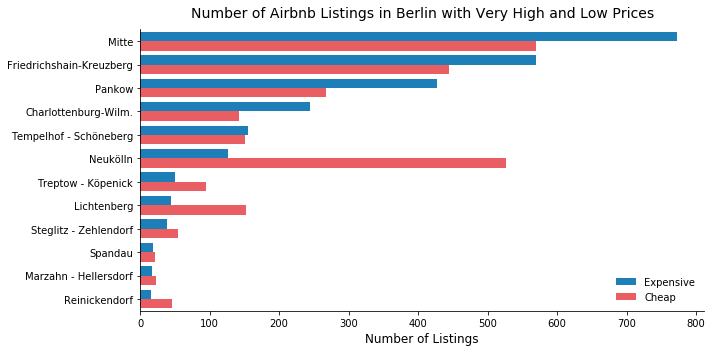

In [13]:
### Visualizing the result

plt.figure(figsize=(10,5))
sns.barplot(x='Listings', y='neighbourhood_group_cleansed', hue='Category', data=extreme_prices, 
            orient="h", palette=["#0485d1", "#ff474c"])

plt.ylabel("")
plt.xlabel("Number of Listings", size=12)
sns.despine()
plt.title("Number of Airbnb Listings in Berlin with Very High and Low Prices", size=14, pad=12)
plt.legend(frameon=False)
plt.tight_layout();

Looking at the distribution of 10% of the most and least expensive listings one can make a couple of interesting observations. Berlin-Mitte, the district in the center of Berlin with many tourist attractions has the most higher priced listings as well as most lower priced listings, reflecting its attraction to a diverse range of visitors.
Other districts, like Neukölln for instance, show a clearer tendency towards a more lower price segment, with a dominance of cheaper listings.

Next, we're going to split up the price structure by the number of beds offered. This should gives as a more granular overview of the price differences between districts.

In [14]:
### Analysing the data

# We're going to look at appartements with at least one and maximally 8 beds
ber_avg_price = ber_avg_price[(ber_avg_price["beds"]<=8) & (ber_avg_price["beds"]>0)]
ber_avg_price["beds"] = ber_avg_price["beds"].astype(int)

price_per_beds = ber_avg_price.groupby(["neighbourhood_group_cleansed", "beds"])["price"].median().unstack()

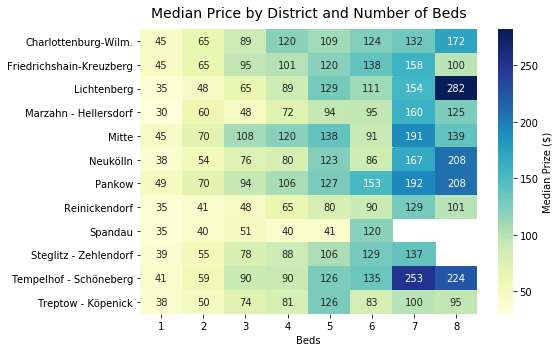

In [15]:
### Visualizing the result

plt.figure(figsize=(8,5))
sns.heatmap(price_per_beds, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Median Prize ($)'})
plt.xlabel("Beds")
plt.ylabel("")
plt.title("Median Price by District and Number of Beds", size=14, pad=12)
plt.tight_layout();

For listing with up to 4 beds a similar picture emerges as before, with Berlin-Mitte for example in the higher price category. In contrast to that, for listings with 5 and more beds this clear separation between districts disappears.

### 2. Do visitor numbers and listing prices fluctuate over the year?

There is no direct way to get the number of actual visitors from the data. However, one can use the amount of written reviews as an indication of the actual number of visitors. This way we can follow the overall trends of Airbnb guests numbers.

In [16]:
### Gathering the data

# Loading the review data for Berlin
ber_reviews_url = "http://data.insideairbnb.com/germany/be/berlin/2019-07-11/visualisations/reviews.csv"
ber_reviews = pd.read_csv(ber_reviews_url)

In [17]:
### Cleaning the data

# Function to generate a dataframe with datetime index from the date column
def datetime_index(df):
    """
    Adds a datetime index to a dataframe with a date column
    Input: Airbnb data dataframe with date column
    Output: dataframe with datetime index
    """
    new_df = df.copy()
    new_df["date"] = pd.to_datetime(new_df["date"])
    new_df.set_index(new_df["date"], inplace=True)
    
    return new_df

In [18]:
### Cleaning the data

# Converting the date column of ber_reviews to datetime and setting a datetime index
ber_reviews = datetime_index(ber_reviews)

# Only selecting the listing_id column with the the datetime index
ber_reviews = ber_reviews[["listing_id"]]

# Adding a datetime index to the calendar data
ber_calendar = datetime_index(ber_calendar)

In [19]:
### Analysing the data

# Selecting the reviews for the last 4 years
ber_reviews = ber_reviews.loc['2015-7-12':'2019-7-11']

# Calculating total reviews per month
# Divided by 4, because we're looking at the average count over a 4 year period
ber_monthly_reviews = ber_reviews.groupby(ber_reviews.index.month).count()/4
ber_monthly_reviews.reset_index(inplace=True)

# Aggregating monthly price data
ber_month_avg = ber_calendar.groupby(ber_calendar.index.month)["price"].mean()
ber_month_avg = ber_month_avg.reset_index()

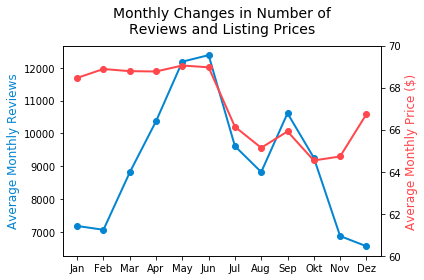

In [20]:
### Visualizing the result

# Adding month abbreviation
months = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
          7:"Jul", 8:"Aug", 9:"Sep", 10:"Okt", 11:"Nov", 12:"Dez"}

ber_month_avg["date"] = ber_month_avg["date"].replace(months)
ber_monthly_reviews["date"] = ber_monthly_reviews["date"].replace(months)


fig, ax1 = plt.subplots(figsize=(6, 4))

color = "#0485d1"
ax1.set_xlabel('')
ax1.set_ylabel('Average Monthly Reviews', color=color, size=12)
ax1.plot(ber_monthly_reviews["date"], ber_monthly_reviews["listing_id"], color=color, marker="o", lw=2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "#ff474c"
ax2.set_ylabel('Average Monthly Price ($)', color=color, size=12) 
ax2.plot(ber_month_avg["date"], ber_month_avg["price"], color=color, marker="o", lw=2)
ax2.set_ylim(60,70)

plt.title("Monthly Changes in Number of\nReviews and Listing Prices", size=14, pad=12)
fig.tight_layout();

May and June are the most popular months for Airbnb users in Berlin. It seems that the winter time on the hand is the least popular time for guests. The average listing price is the lowest in October and November, with about 65\\$. Surprisingly the average price rises then throughout December to the high level of around 69$ in January and February, where the guest numbers are actually relatively low.

### 3. How do Airbnb prices in Berlin compare to another large german city, Munich?

In [21]:
### Gathering the data

# Loading the calendar data for Munich
mun_calendar_url = "http://data.insideairbnb.com/germany/bv/munich/2019-07-16/data/calendar.csv.gz"
mun_calendar = pd.read_csv(mun_calendar_url)

In [22]:
### Cleaning the data

# Converting the price variable in mun_calendar to numeric
mun_calendar["price"] = num_price(mun_calendar["price"])

In [23]:
# Looking at the distribution of the price variable
mun_calendar["price"].describe()

count    3.736870e+06
mean     1.136084e+02
std      1.262568e+02
min      9.000000e+00
25%      5.500000e+01
50%      8.000000e+01
75%      1.290000e+02
max      5.000000e+03
Name: price, dtype: float64

In [24]:
# We're going to take the same cutoff for the maximum price per night as before for Berlin. 
# How many rows do we have to drop?
mun_calendar["price"][mun_calendar["price"] > 2000].count()

1337

In [25]:
# Droping the rows with unrealistically high prices  
mun_calendar.drop(mun_calendar[mun_calendar["price"] > 2000].index, inplace=True)

In [26]:
# Checking for null values that have been generated by converting to numeric
mun_calendar["price"].isnull().sum()

0

In [27]:
### Analysing the data

# Calculating the average price for every listing throughout the whole year
mun_avg_price = mun_calendar.groupby("listing_id")["price"].mean()
mun_avg_price = mun_avg_price.reset_index()

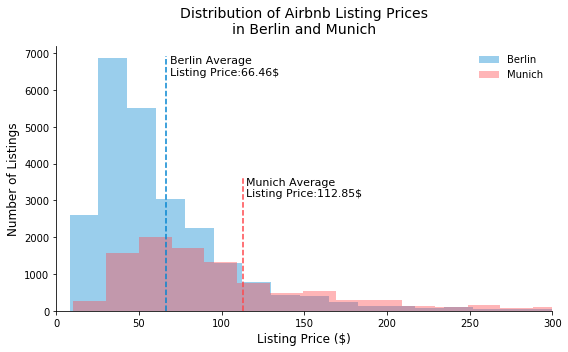

In [28]:
### Visualizing the result

plt.figure(figsize=(8,5))
sns.distplot(ber_avg_price["price"] , color="#0485d1", label="Berlin", kde=False, bins=100)

ber_mean = ber_avg_price["price"].mean()
plt.axvline(ber_mean, color="#0485d1", linestyle='--', ymax=0.96)
plt.text(69, 6400, "Berlin Average\nListing Price:{:.2f}$".format(ber_mean), fontsize = 11)

sns.distplot(mun_avg_price["price"] , color="#ff474c", label="Munich", kde=False, bins=100)

mun_mean = mun_avg_price["price"].mean()
plt.axvline(mun_mean, color="#ff474c", linestyle='--', ymax=0.5)
plt.text(115, 3100, "Munich Average\nListing Price:{:.2f}$".format(mun_mean), fontsize = 11)

plt.xlim(0, 300)
plt.xlabel("Listing Price ($)", size=12)
plt.ylabel("Number of Listings", size=12)
plt.title("Distribution of Airbnb Listing Prices\nin Berlin and Munich", size=14, pad=12)
sns.despine()
plt.tight_layout()
plt.legend(frameon=False);

The comparison of the price distributions shows that Berlin has more listings in total and more listings in lower price segments (< 50\\$). Munich on the other hand has a higher proportion of highly priced listings. Accordingly the average listing price in Munich is 112.85\\$ compared to 66.46$ in Berlin.

In [29]:
### Gathering the data

# Loading the review data for Munich
mun_reviews_url = "http://data.insideairbnb.com/germany/bv/munich/2019-07-16/visualisations/reviews.csv"
mun_reviews = pd.read_csv(mun_reviews_url)

In [30]:
# Converting the date column of mun_reviews to datetime and setting a datetime index
mun_reviews = datetime_index(mun_reviews)

# Only selecting the listing_id column with the the datetime index
mun_reviews = mun_reviews[["listing_id"]]

# Selecting the reviews for the last 4 years
mun_reviews = mun_reviews.loc['2015-7-12':'2019-7-11']

# Calculating total reviews per month
# Divided by 4, because we're looking at the average count over a 4 year period
mun_monthly_reviews = mun_reviews.groupby(mun_reviews.index.month).count()/4
mun_monthly_reviews.reset_index(inplace=True)

# Adding month abbreviations
mun_monthly_reviews["date"] = mun_monthly_reviews["date"].replace(months)

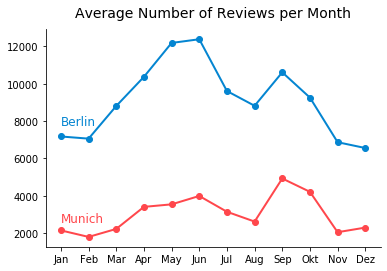

In [31]:
### Visualizing the result

plt.figure(figsize=(6,4))
plt.plot(ber_monthly_reviews["date"], ber_monthly_reviews["listing_id"], marker="o", lw=2, color="#0485d1")
plt.plot(mun_monthly_reviews["date"], mun_monthly_reviews["listing_id"], marker="o", lw=2, color="#ff474c")

plt.ylabel("")
plt.text(0,7800, "Berlin", size=12, color="#0485d1")
plt.text(0,2600, "Munich", size=12, color="#ff474c")
plt.title("Average Number of Reviews per Month", size=14, pad=12)
sns.despine();

Comparing the number of monthly reviews, we can see that for Munich, contrary to Berlin, the peak of visitors seems to be in September. This coincides with the beginning of the traditional Oktoberfest, with many tourists visiting from around the world. Similarly to Berlin the winter months seem to be a period of relatively low levels of Airbnb guests.